## **EDA and Preprocessing**
- WNBA Shots Dataset
- Removed unhelpful attributes

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc
import numpy as np
from sklearn.preprocessing import LabelEncoder
from ydata_profiling import ProfileReport

data = pd.read_csv('wnba-shots-2021.csv')

In [38]:
data.head(1)

game_id  game_play_number  \
0  401391650                 4   

                                                desc  shot_type  made_shot  \
0  Shatori Walker-Kimbrough blocks Destanni Hende...  Jump Shot      False   

   shot_value  coordinate_x  coordinate_y shooting_team home_team_name  \
0           0            37             9       Indiana     Washington   

  away_team_name  home_score  away_score  qtr  quarter_seconds_remaining  \
0        Indiana           0           0    1                        571   

   game_seconds_remaining  
0                    2371

### **1. Removing unnecessary attributes**
- The tasks / questions we need to answer are:
    - Classification model to predict the shot outcome based on the coordinates of the shot
    - Visualization displaying the joint frequency of shot locations / team / shot type
    - Glass-Box model
    - Black-Box model
    - Pre and Post Modeling XAI
- We do not want attributes that do not give us information for the tasks such as:
    - game_id, game_play_number, desc, shooting_team, home_team_name, away_team_name
- We consider these attributes irrelevant also for XAI tasks


In [68]:
# Removing attributes
columns_to_remove = ['game_id', 'game_play_number', 'desc', 'shooting_team', 'home_team_name', 'away_team_name']
data = data.drop(columns=columns_to_remove)
data.head(1)

shot_type  made_shot  shot_value  coordinate_x  coordinate_y  home_score  \
0  Jump Shot      False           0            12             9           0   

   away_score  qtr  quarter_seconds_remaining  game_seconds_remaining  \
0           0    1                        571                    2371   

  shot_group  distance  shot_group_encoded  shot_type_encoded  
0  Jump Shot      15.0                   5                 56

In [69]:
# Profiling the data
prf = ProfileReport(data)
prf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
# Why are coordinates with such a low value? Lets investigate

In [70]:
print(data['coordinate_x'].max())
print(data['coordinate_x'].min())
print(data['coordinate_x'].mean())
print(data['coordinate_y'].max())
print(data['coordinate_y'].min())
print(data['coordinate_y'].mean())

25
-25
-0.16283104802756826
81
0
10.858616285514616


In [71]:
negativesx = data[data['coordinate_x']< 0]
negativesy = data[data['coordinate_y'] < 0]
print(negativesx.head(5))
print(negativesy.head(5))

                   shot_type  made_shot  shot_value  coordinate_x  \
1  Turnaround Bank Jump Shot      False           0           -13   
3         Driving Layup Shot       True           2            -3   
4                  Jump Shot       True           3           -16   
6         Driving Layup Shot       True           2            -3   
8           Pullup Jump Shot       True           2           -13   

   coordinate_y  home_score  away_score  qtr  quarter_seconds_remaining  \
1             0           0           0    1                        551   
3             0           2           2    1                        524   
4            21           2           5    1                        512   
6             3           4           7    1                        478   
8             4           6           8    1                        461   

   game_seconds_remaining shot_group   distance  shot_group_encoded  \
1                    2351  Jump Shot  13.000000                

In [72]:
# Apparently this error occurs with every free throw entry, so lets fix it.
# The free throw line position is centered 15' from the backboard according to the official wnba rules 
# (https://www.wnba.com/archive/wnba/analysis/rule_one.html)
# So we set every free throw shot to the coordinate (25, 15)

In [73]:
data['coordinate_x'] = data['coordinate_x'].apply(lambda x: 25 if x < 0 else x)
data['coordinate_y'] = data['coordinate_y'].apply(lambda y: 15 if y < 0 else y)


In [74]:
print(data['coordinate_x'].max())
print(data['coordinate_x'].min())
print(data['coordinate_x'].mean())
print(data['coordinate_y'].max())
print(data['coordinate_y'].min())
print(data['coordinate_y'].mean())

25
0
11.691062004482252
81
0
10.858616285514616


### **2. Creating new features**
- Adjuster hoop to be at coordinates 0,0
- Created distance attribute
- Grouped shot_types

In [75]:
# Adjust coordinates to center the hoop at 0,0
data['coordinate_x'] = data['coordinate_x'] - 25
data['coordinate_y'] = data['coordinate_y']

# Euclidean distance
data['distance'] = np.sqrt(data['coordinate_x']**2 + data['coordinate_y']**2)

data.head(1)

shot_type  made_shot  shot_value  coordinate_x  coordinate_y  home_score  \
0  Jump Shot      False           0           -13             9           0   

   away_score  qtr  quarter_seconds_remaining  game_seconds_remaining  \
0           0    1                        571                    2371   

  shot_group   distance  shot_group_encoded  shot_type_encoded  
0  Jump Shot  15.811388                   5                 56

Now we will have negative values for coordinate x again but now controlled, going from -25 to 25

In [76]:

# Define shot groups
shot_groups = {
    'Free Throw': [
        'Free Throw - 1 of 1', 'Free Throw - 1 of 2', 'Free Throw - 1 of 3',
        'Free Throw - 2 of 2', 'Free Throw - 2 of 3', 'Free Throw - 3 of 3',
        'Free Throw - Clear Path 1 of 2', 'Free Throw - Clear Path 2 of 2',
        'Free Throw - Flagrant 1 of 1', 'Free Throw - Flagrant 1 of 2', 
        'Free Throw - Flagrant 1 of 3', 'Free Throw - Flagrant 2 of 2',
        'Free Throw - Flagrant 2 of 3', 'Free Throw - Flagrant 3 of 3',
        'Free Throw - Technical'
    ],
    'Jump Shot': [
        'Jump Shot', 'Pullup Jump Shot', 'Fade Away Jump Shot', 'Step Back Jump Shot',
        'Turnaround Jump Shot', 'Turnaround Fade Away Jump Shot',
        'Turnaround Fadeaway Bank Jump Shot', 'Turnaround Bank Jump Shot',
        'Step Back Bank Jump Shot', 'Pullup Bank Jump Shot', 'Driving Jump Shot Bank',
        'Driving Floating Jump Shot', 'Jump Shot Bank', 'Floating Jump Shot',
        'Running Pullup Jump Shot', 'Running Jump Shot', 'Driving Floating Bank Jump Shot',
        'Fade Away Bank Jump Shot'
    ],
    'Layup': [
        'Layup Shot', 'Driving Layup Shot', 'Running Layup Shot', 'Reverse Layup Shot',
        'Driving Finger Roll Layup', 'Running Finger Roll Layup', 'Cutting Finger Roll Layup Shot',
        'Layup Running Reverse', 'Layup Driving Reverse', 'Layup Shot Putback', 
        'Cutting Layup Shot', 'Alley Oop Layup Shot', 'Running Alley Oop Layup Shot',
        'Finger Roll Layup'
    ],
    'Dunk': [
        'Dunk Shot', 'Driving Dunk Shot', 'Running Dunk Shot', 'Alley Oop Dunk Shot'
    ],
    'Hook Shot': [
        'Hook Shot', 'Driving Hook Shot', 'Turnaround Hook Shot', 'Hook Driving Bank',
        'Hook Shot Bank', 'Hook Turnaround Bank'
    ],
    'Tip Shot': ['Tip Shot'],
    'Other': ['No Shot (Default Shot)']
}

# Apply the grouping
shot_type_to_group = {shot: group for group, shots in shot_groups.items() for shot in shots}
data['shot_group'] = data['shot_type'].map(shot_type_to_group)
data.head(1)

shot_type  made_shot  shot_value  coordinate_x  coordinate_y  home_score  \
0  Jump Shot      False           0           -13             9           0   

   away_score  qtr  quarter_seconds_remaining  game_seconds_remaining  \
0           0    1                        571                    2371   

  shot_group   distance  shot_group_encoded  shot_type_encoded  
0  Jump Shot  15.811388                   5                 56

### **3. Encoding non numarical features**
- Used Sklearn LabelEncoder
- Encoded:
    - shot_type
    - shot_group

In [77]:
# Calculate the average distance per shot group
avg_distance_per_group = data.groupby('shot_group')['distance'].mean().sort_values()
avg_distance_per_type = data.groupby('shot_type')['distance'].mean().sort_values()

shot_group_order = {group: i for i, group in enumerate(avg_distance_per_group.index)}
shot_type_order = {type: i for i, type in enumerate(avg_distance_per_type.index)}

data['shot_group_encoded'] = data['shot_group'].map(shot_group_order)
data['shot_type_encoded'] = data['shot_type'].map(shot_type_order)
data["shot_group_encoded"] = data["shot_group_encoded"].astype(int)
data.head(1)

shot_type  made_shot  shot_value  coordinate_x  coordinate_y  home_score  \
0  Jump Shot      False           0           -13             9           0   

   away_score  qtr  quarter_seconds_remaining  game_seconds_remaining  \
0           0    1                        571                    2371   

  shot_group   distance  shot_group_encoded  shot_type_encoded  
0  Jump Shot  15.811388                   3                 29

In [78]:
# Save the dataset
data.to_csv('wnba_clean.csv', index=False)

### **4. EDA**
- Number of shots per each shot group
- Successn rate per shot group
- Shot location heatmap

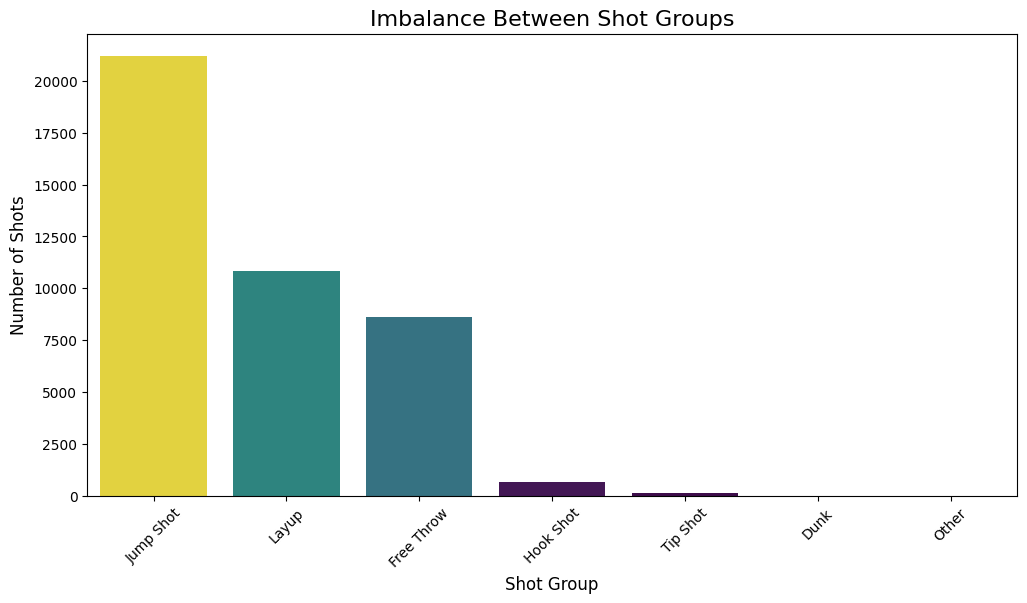

In [61]:
# Count the number of shots in each shot group
group_counts = data['shot_group'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis", hue=group_counts, legend=False)
plt.title('Imbalance Between Shot Groups', fontsize=16)
plt.xlabel('Shot Group', fontsize=12)
plt.ylabel('Number of Shots', fontsize=12)
plt.xticks(rotation=45)
plt.show()

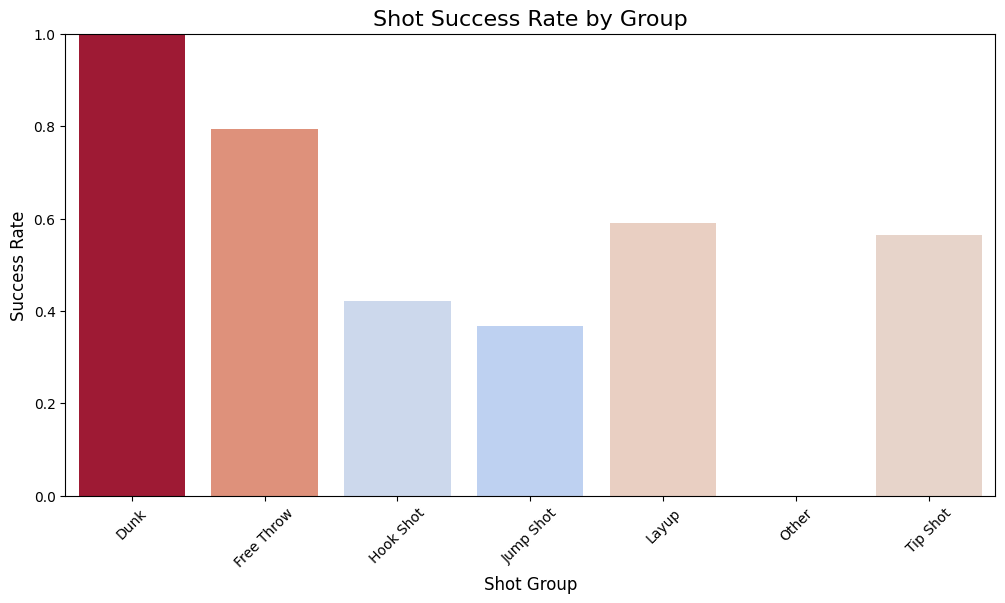

In [62]:
# Success rate for each shot group
group_success_rates = data.groupby('shot_group')['made_shot'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=group_success_rates.index, y=group_success_rates.values, palette="coolwarm", hue=group_success_rates, legend=False)
plt.title('Shot Success Rate by Group', fontsize=16)
plt.xlabel('Shot Group', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [63]:
# Draw court function
def draw_court(ax, color='black', lw=2):
    hoop = Circle((0, 0), radius=0.75, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-3, -1), 6, -0.1, linewidth=lw, color=color)
    outer_box = Rectangle((-8, -4.8), 16, 19, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-6, -4.8), 12, 19, linewidth=lw, color=color, fill=False)
    free_throw_top = Arc((0, 14.6), 12, 12, theta1=0, theta2=180, linewidth=lw, color=color)
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color)
    three_point_arc = Arc((0, 0), 47.5, 47.5, theta1=22, theta2=158, linewidth=lw, color=color)
    corner_three_a = Rectangle((-22, 0), 0, 14, linewidth=lw, color=color)
    corner_three_b = Rectangle((22, 0), 0, 14, linewidth=lw, color=color)
    court_elements = [
        hoop, backboard, outer_box, inner_box, free_throw_top, restricted,
        three_point_arc, corner_three_a, corner_three_b
    ]

    for element in court_elements:
        ax.add_patch(element)

    ax.set_xlim(-25, 25)
    ax.set_ylim(0, 47)
    ax.set_aspect(1)

    return ax

In [64]:
# Create heatmap
x_bins = np.linspace(-25, 25, 50)
y_bins = np.linspace(0, 47, 50)
made_shots = data[data['made_shot'] == True]

heatmap, xedges, yedges = np.histogram2d(
    made_shots['coordinate_x'],
    made_shots['coordinate_y'],
    bins=[x_bins, y_bins])

heatmap = np.rot90(heatmap)
heatmap = np.flipud(heatmap)

# Apply logarithmic transformation to reduce variance
log_heatmap = np.log1p(heatmap)
# Normalize the log-transformed heatmap
log_heatmap_normalized = log_heatmap / np.max(log_heatmap)

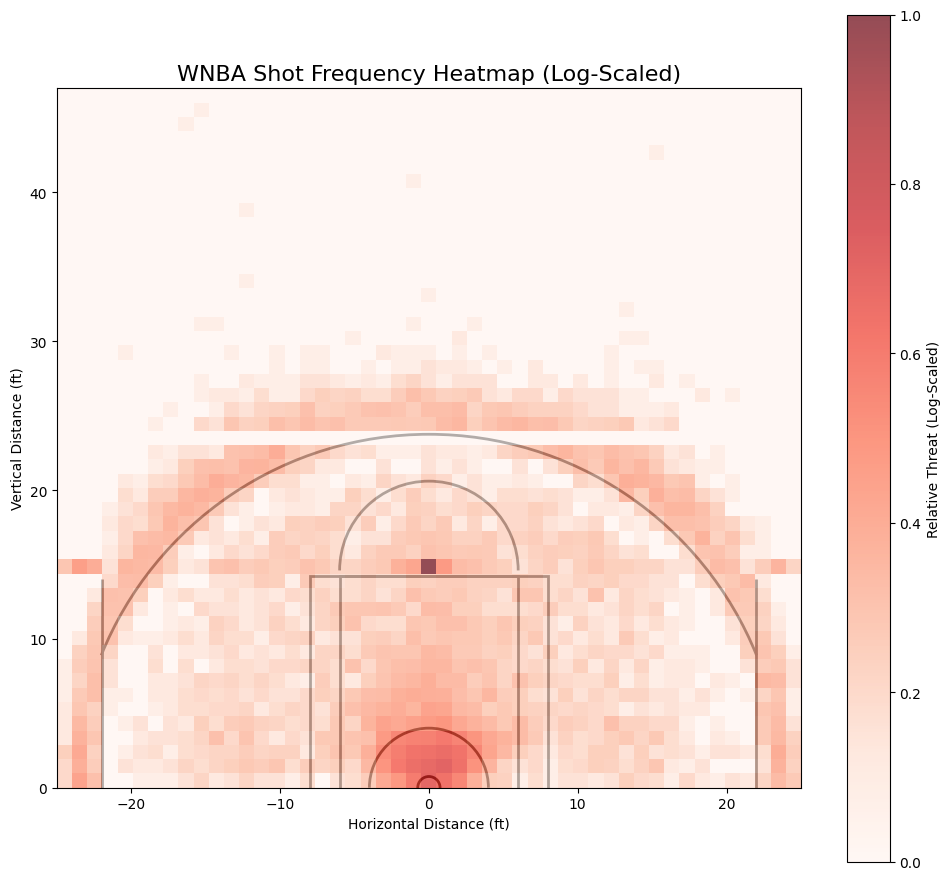

In [65]:
# Shot location heatmap
plt.figure(figsize=(12, 11))
ax = plt.gca()
draw_court(ax)
c = ax.pcolormesh(xedges, yedges, log_heatmap_normalized, cmap='Reds', alpha=0.7)
plt.colorbar(c, ax=ax, label='Relative Threat (Log-Scaled)')

ax.set_title('WNBA Shot Frequency Heatmap (Log-Scaled)', fontsize=16)
ax.set_xlabel('Horizontal Distance (ft)')
ax.set_ylabel('Vertical Distance (ft)')
plt.show()